In [14]:
import pandas as pd
import numpy as np
csv_path = r"C:\Users\Administrator\Downloads\winequality-red-selected-missing.csv"
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum())
print("\nQuality distribution:\n", df['quality'].value_counts().sort_index())
df.head()

Shape: (1599, 12)
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Missing values per column:
 fixed acidity             0
volatile acidity          0
citric acid             211
residual sugar            0
chlorides                 0
free sulfur dioxide       0
total sulfur dioxide      0
density                 194
pH                      210
sulphates                 0
alcohol                   0
quality                   0
dtype: int64

Quality distribution:
 quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,NaN,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [29]:
df['good'] = (df['quality'] >= 7).astype(int)
print("Binary target distribution:\n", df['good'].value_counts(), "\nProportions:\n", df['good'].value_counts(normalize=True))

X = df.drop(columns=['quality', 'good'])
y = df['good']
X.columns.tolist()


Binary target distribution:
 good
0    1382
1     217
Name: count, dtype: int64 
Proportions:
 good
0    0.86429
1    0.13571
Name: proportion, dtype: float64


['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

Columns with missing values:
 citric acid    211
density        194
pH             210
dtype: int64


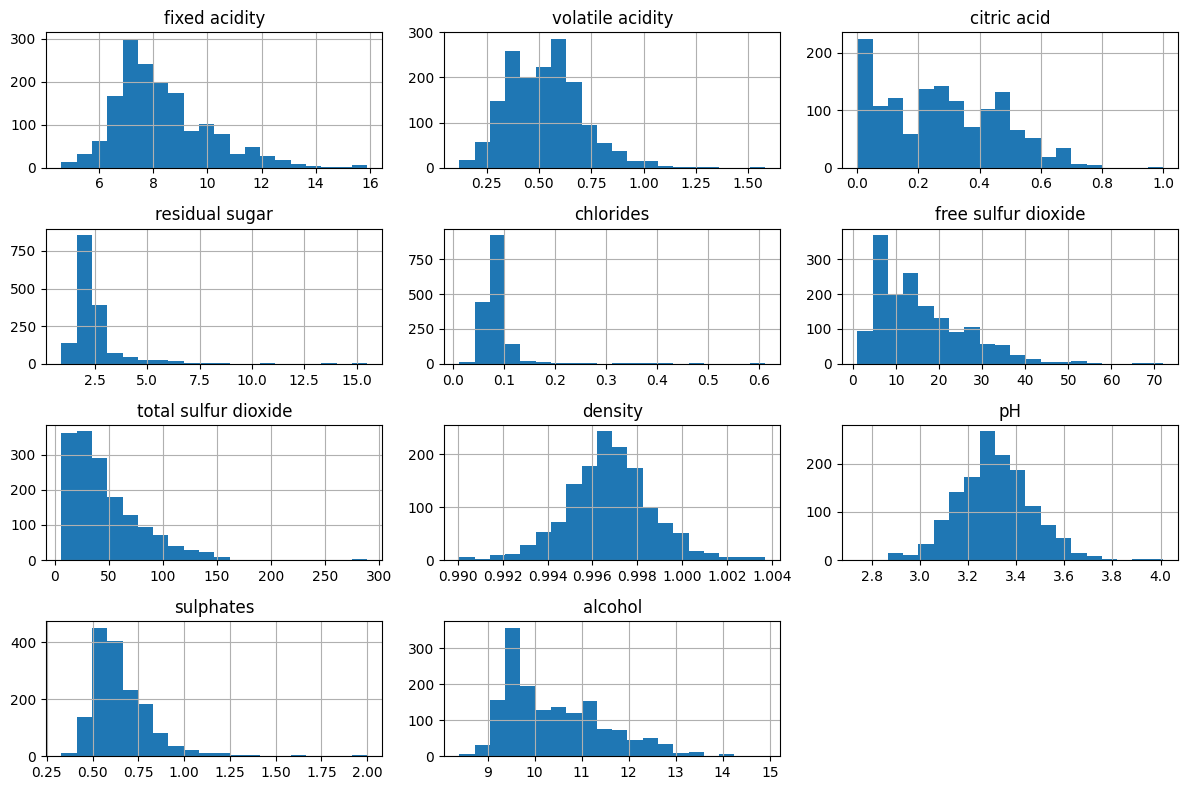

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

missing = df.isna().sum()
print("Columns with missing values:\n", missing[missing>0])

_ = X.hist(bins=20, figsize=(12,8), layout=(4,3))
plt.tight_layout()


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

pipeline.fit(X_train, y_train)
print("Baseline training complete.")


Train shape: (1279, 11) Test shape: (320, 11)
Baseline training complete.


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC (avg precision):", average_precision_score(y_test, y_proba))



Classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       277
           1       0.96      0.60      0.74        43

    accuracy                           0.94       320
   macro avg       0.95      0.80      0.86       320
weighted avg       0.94      0.94      0.94       320

Confusion matrix:
 [[276   1]
 [ 17  26]]
ROC AUC: 0.9474015615817312
PR AUC (avg precision): 0.8283651414485841


In [21]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [None, 8, 16, 32],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__class_weight': ['balanced']
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
print("Best params:", search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'clf__n_estimators': 400, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': 16, 'clf__class_weight': 'balanced'}


In [22]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC (avg precision):", average_precision_score(y_test, y_proba))


Classification report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       277
           1       0.79      0.70      0.74        43

    accuracy                           0.93       320
   macro avg       0.87      0.83      0.85       320
weighted avg       0.93      0.93      0.93       320

Confusion matrix:
 [[269   8]
 [ 13  30]]
ROC AUC: 0.9391318948870793
PR AUC (avg precision): 0.802134977489675


alcohol                 0.272989
sulphates               0.137594
volatile acidity        0.117990
total sulfur dioxide    0.075745
citric acid             0.073712
chlorides               0.064850
density                 0.064224
fixed acidity           0.057616
pH                      0.048611
residual sugar          0.044486
free sulfur dioxide     0.042184
dtype: float64


Text(0.5, 1.0, 'Feature importances')

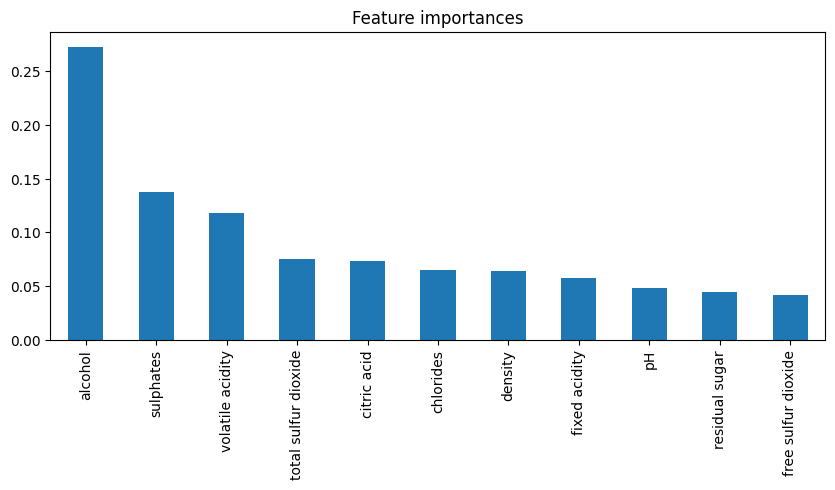

In [31]:
clf = best_model.named_steps['clf']
feat_names = X.columns.tolist()
importances = clf.feature_importances_
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)
print(fi)
fi.plot(kind='bar', figsize=(10,4)); plt.title("Feature importances")


In [32]:
import joblib
artifact = {
    "estimator": best_model,  # pipeline containing preprocessing and clf
    "feature_names": X.columns.tolist()
}
joblib.dump(artifact, "model_artifact.joblib")
print("Saved model_artifact.joblib")


Saved model_artifact.joblib
